In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import matplotlib.image as mtlimg
import pdb

# 1. Find corners of Chessboard


In [2]:
def get_chess_image_point_corner_pts(num_row, num_col, glob_path, is_plot=False, is_debug=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((num_col*num_row,3), np.float32)
    objp[:,:2] = np.mgrid[0:num_row, 0:num_col].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(glob_path)
    print ("found " + str(len(images)) + " image")
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        
        if is_debug: print ("Processing " + fname, end = ', ')
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (num_row, num_col), None)

        # If found, add object points, image points
        if ret == True:
            if is_debug: print ("found corner:" + str(num_row) + "x" + str(num_col), end= " ,")
            print (".", end=" ")    
            objpoints.append(objp)
            imgpoints.append(corners)

            if is_plot:
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (num_row ,num_col), corners, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)

    cv2.destroyAllWindows() 
    return objpoints, imgpoints
    
#def calibate_camera(glob_path, ):

In [3]:
glob_path = 'camera_cal/calibration*.jpg'

In [4]:
objpoints, imgpoints = get_chess_image_point_corner_pts(9, 6, glob_path, is_plot=False, is_debug=False)
print ("done")

found 24 image
. . . . . . . . . . . . . . . . . . done


# 2. Calibrate and UnDistort image

In [5]:
def calibrate_camera(objpoints, imgpoints, img):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    cal_dict = {}
    cal_dict['mtx'] = mtx
    cal_dict['dist'] = dist
    return cal_dict

def un_distort_image(img, cal_dict):
    dst = cv2.undistort(img, cal_dict['mtx'], cal_dict['dist'], None, cal_dict['mtx'])
    return dst

def get_un_distort_from_distorted_image(test_image_path, objpoints, imgpoints):
    img = cv2.imread(test_image_path)
    calibration_dict = calibrate_camera(objpoints, imgpoints, img)
    img_un_dist = un_distort_image(img, calibration_dict)
    return img, img_un_dist, calibration_dict
    
def plot_two_images(img1, img2, left_title="Left Image", right_title="Right image", plot_diff=True):
    num_col = 2
    if plot_diff:
        num_col = 3 
    
    f, axes = plt.subplots(1, num_col, figsize=(20,10))
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(left_title, fontsize=20)
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(right_title, fontsize=20)    
    if plot_diff:
        if len(img2.shape) == 2:
            diff_sq = (img2 - img1)**2
            scale_factor = np.max(diff_sq)/255 
            diff_scaled = (diff_sq/scale_factor).astype(np.uint8)             
            axes[2].imshow(diff_scaled, cmap='gray')
        else:
            axes[2].imshow(np.sum((img2 - img1)**2, axis=2), cmap='gray')
#         axes[2].imshow((img2 - img1), cmap='gray')
        axes[2].set_title("Diff image", fontsize=20)    
    
def plot_distorted_image_un_distorted_image(image_path, objpoints, imgpoints, is_plot=False, plot_diff=True):
    img, img_un_dist, calibration_dict = get_un_distort_from_distorted_image(image_path, objpoints, imgpoints)
    if is_plot:
        plot_two_images(img, img_un_dist, left_title="Original image", right_title="Undistorted image", 
                        plot_diff=plot_diff)
    return img, img_un_dist, calibration_dict


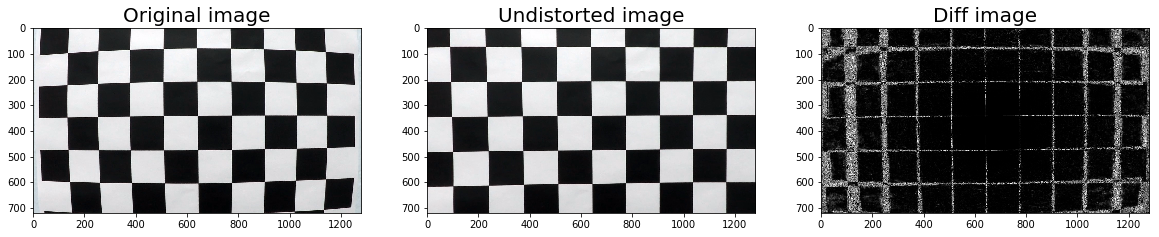

In [6]:
%matplotlib inline

_ = plot_distorted_image_un_distorted_image("camera_cal/calibration1.jpg", objpoints, imgpoints, is_plot=True)

In [7]:
_  = plot_distorted_image_un_distorted_image("camera_cal/calibration2.jpg", objpoints, imgpoints, is_plot=True)

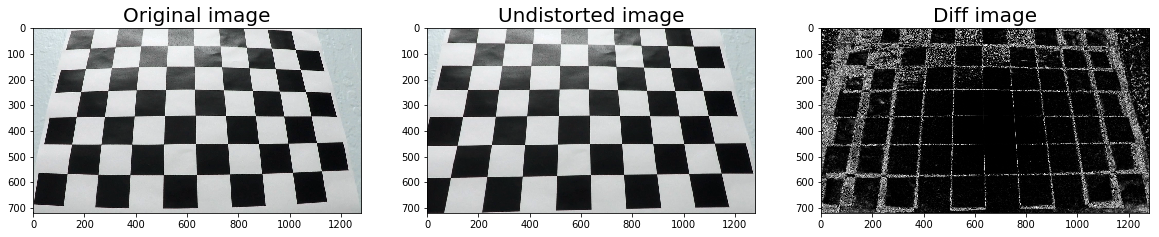

In [26]:
_ = plot_distorted_image_un_distorted_image("camera_cal/calibration3.jpg", objpoints, imgpoints, is_plot=True)

In [7]:
cal_image = cv2.imread("camera_cal/calibration1.jpg")
cal_dict = calibrate_camera(objpoints, imgpoints, cal_image)
print ("done")

done


# 3. Step to perform Perspective Transform

In [8]:
def get_perspective_transform(src, dest, undist_image):
    img_size = (undist_image.shape[1], undist_image.shape[0])
    M = cv2.getPerspectiveTransform(src, dest)
    warped = cv2.warpPerspective(undist_image, M, img_size, flags=cv2.INTER_LINEAR)
    M_INV = cv2.getPerspectiveTransform(dest, src)
    un_warped = cv2.warpPerspective(warped, M_INV, img_size, flags=cv2.INTER_LINEAR)
    
    return M, warped, un_warped

In [12]:
perspective_image_path = "test_images/straight_lines1.jpg"
pesp_img = cv2.imread(perspective_image_path)
img_un_dist= un_distort_image(pesp_img, cal_dict)
pesp_img_rgb = cv2.cvtColor(img_un_dist, cv2.COLOR_BGR2RGB)

plot_two_images(cv2.cvtColor(pesp_img, cv2.COLOR_BGR2RGB), pesp_img_rgb)


In [13]:
%matplotlib qt

print (pesp_img_rgb.shape)
plt.imshow(pesp_img_rgb)
plt.plot(220, 720, ".")
plt.plot(1100, 720, ".")
plt.plot(674, 440, ".")
plt.plot(608, 440, ".")


(720, 1280, 3)


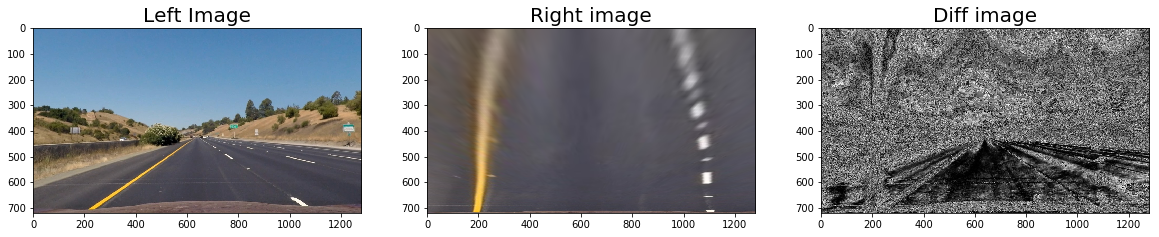

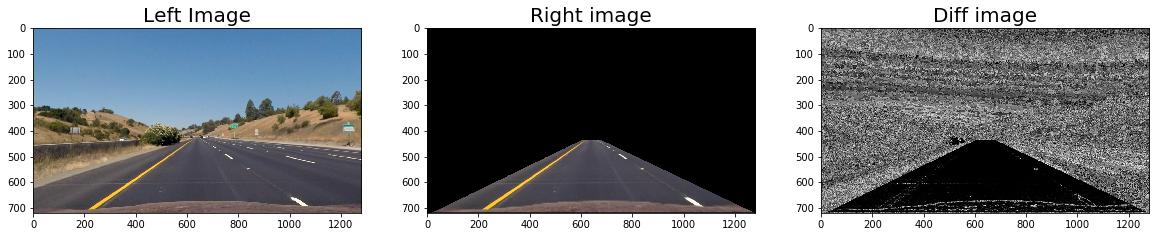

In [14]:
src_pnts = np.float32([
  [220, 720],
  [1100, 720],
  [674, 440],    
  [608, 440]

])
dst_pnts = np.float32([
  [207, 720],
  [1100, 720],
  [1100, 110],    
  [207,  110]
])

%matplotlib inline

M, warped, un_warped = get_perspective_transform(src_pnts, dst_pnts, img_un_dist)
warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
un_warped_rgb = cv2.cvtColor(un_warped, cv2.COLOR_BGR2RGB)
plot_two_images(pesp_img_rgb, warped_rgb)
plot_two_images(pesp_img_rgb, un_warped_rgb)


In [15]:
cv2.destroyAllWindows()

# 3. Apply image gradients 

## 3.1. Magnitude of the Gradient

In [16]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def magnitute_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

## 3.2. Applying absolute of Sobel

In [17]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

## 3.3. Direction of gradient

In [18]:
# Define a function to threshold an image on directon for a given range and Sobel kernel
def direction_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

### Apply above 3 functions

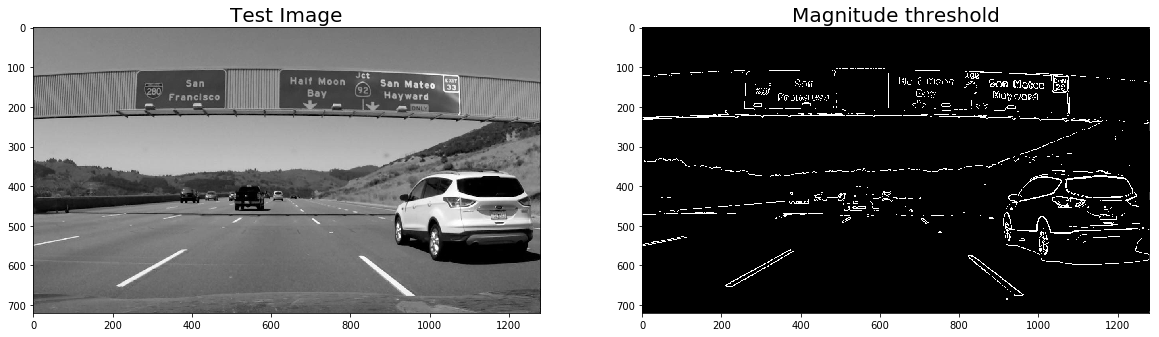

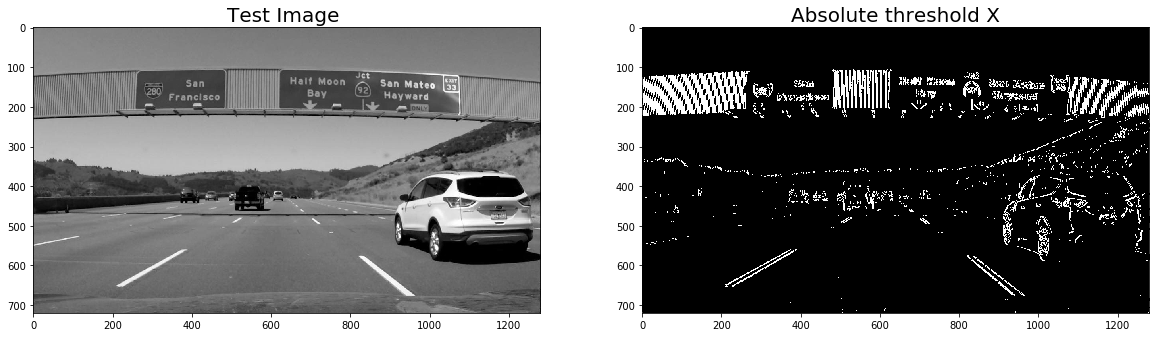

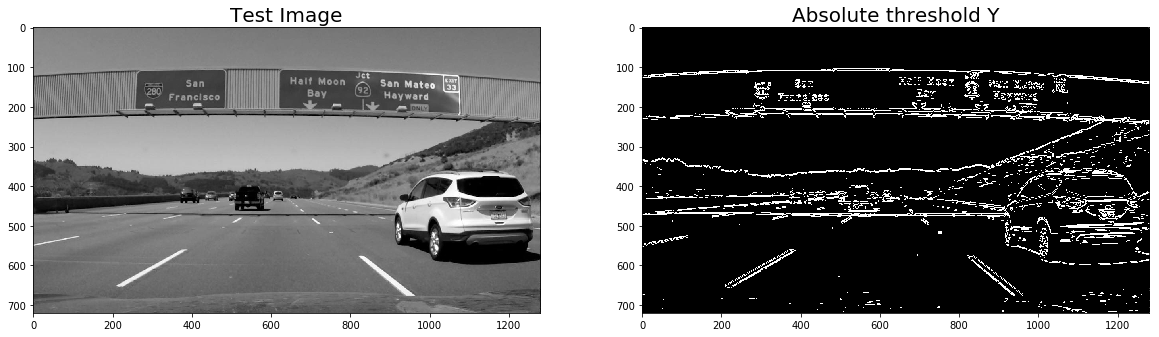

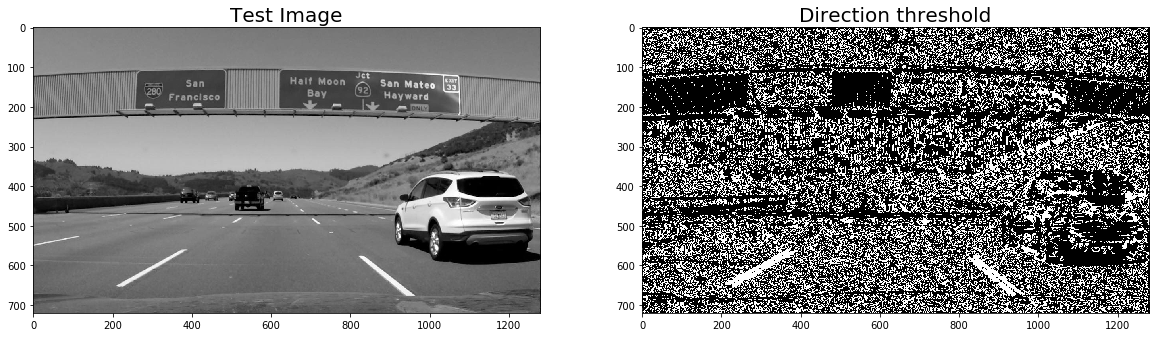

In [20]:
%matplotlib inline

test_image_path = "test_images/signs_vehicles_xygrad.png"
test_image = cv2.imread(test_image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

mag_thres_test = magnitute_thresh(test_image_rgb, sobel_kernel=5, mag_thresh=(70, 200))
grad_binary_test_x = abs_sobel_thresh(test_image_rgb, sobel_kernel=5, orient='x', thresh_min=25, thresh_max=90)
grad_binary_test_y = abs_sobel_thresh(test_image_rgb, sobel_kernel=5, orient='y', thresh_min=25, thresh_max=90)
dir_thres_test = direction_threshold(test_image_rgb, sobel_kernel=15, dir_thresh=(0.7, 1.3))
test_image_gray = cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2GRAY)

#combined_binary [((grad_binary_test_x == 1) & (grad_binary_test_y == 1)) | ((mag_thres_test == 1) & (dir_thres_test==1))] = 1

def combine_and_x_y_or_and_mag_dir(grad_x, grad_y, mag_thres, dir_thres):
    return ((grad_binary_test_x == 1) & (grad_binary_test_y == 1)) | ((mag_thres_test == 1) & (dir_thres_test==1))

def factory_combine_gradients_mag_direction (grad_x, grad_y, mag_thres, dir_thres, mode=1):
    combined_binary = np.zeros_like(dir_thres)
    if mode == 1:
        return combine_and_x_y_or_and_mag_dir(grad_x, grad_y, mag_thres, dir_thres)
    raise Exception("Invalid mode:" + str(mode))
        
    

plot_two_images(test_image_gray, mag_thres_test, left_title="Test Image", right_title="Magnitude threshold", plot_diff=False)
plot_two_images(test_image_gray, grad_binary_test_x, left_title="Test Image ", right_title="Absolute threshold X", plot_diff=False)
plot_two_images(test_image_gray, grad_binary_test_y, left_title="Test Image", right_title="Absolute threshold Y" , plot_diff=False)

plot_two_images(test_image_gray, dir_thres_test, left_title="Test Image", right_title="Direction threshold", plot_diff=False)




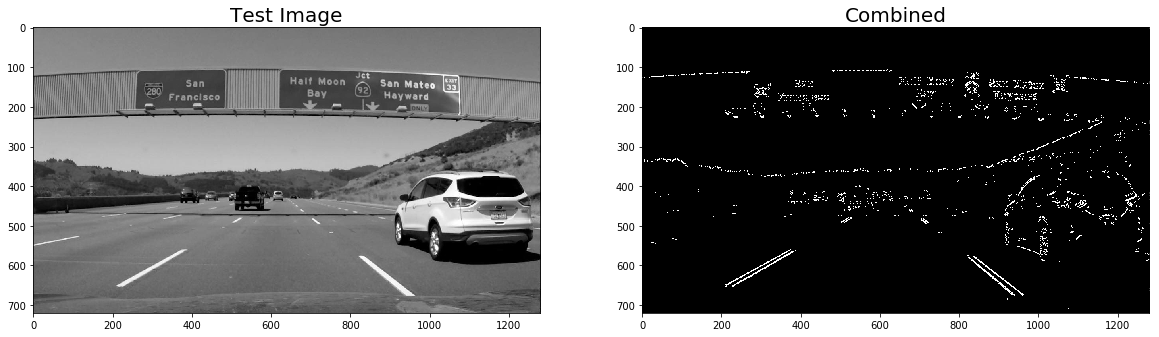

In [21]:
combin_binary = factory_combine_gradients_mag_direction(grad_binary_test_x, grad_binary_test_y, mag_thres_test, dir_thres_test)
plot_two_images(test_image_gray, combin_binary, left_title="Test Image", right_title="Combined", plot_diff=False)


## 4. Apply Color spaces

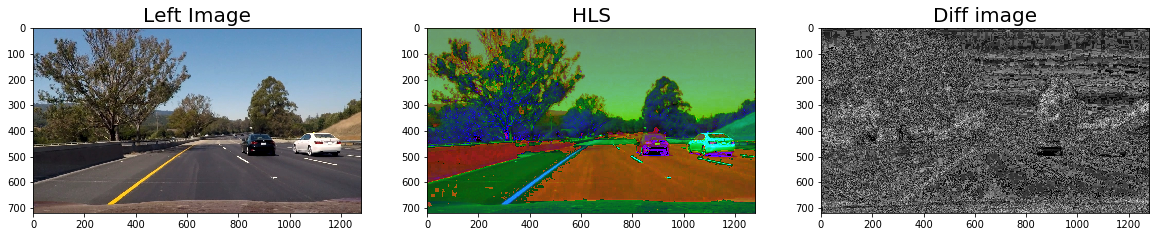

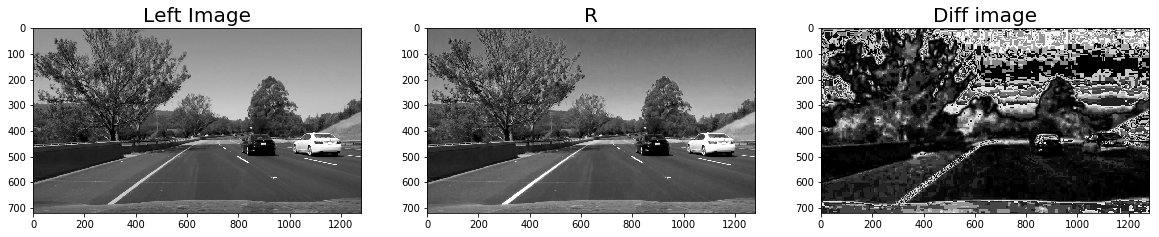

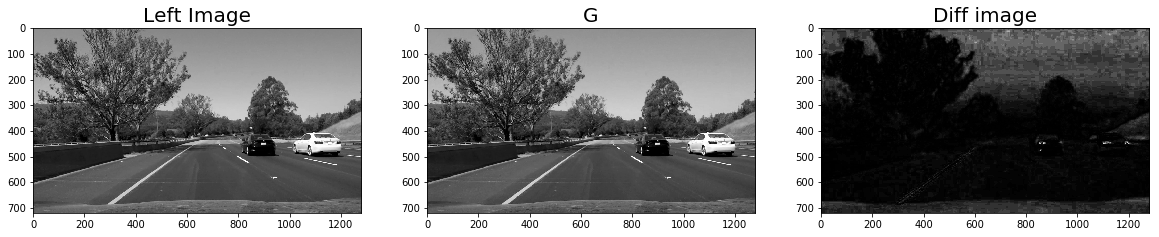

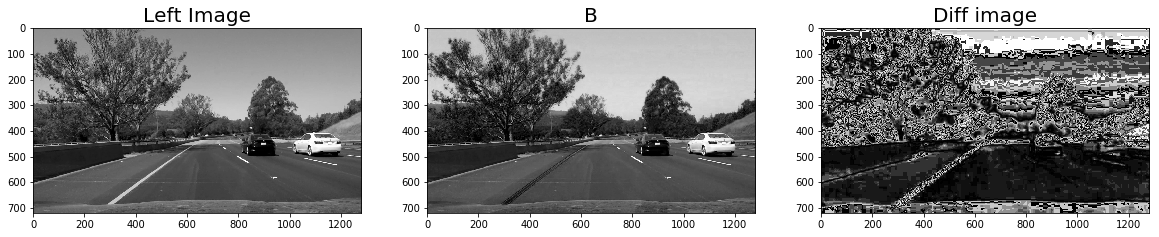

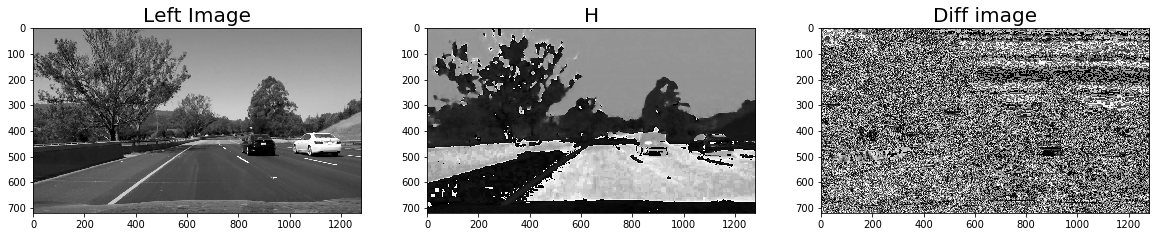

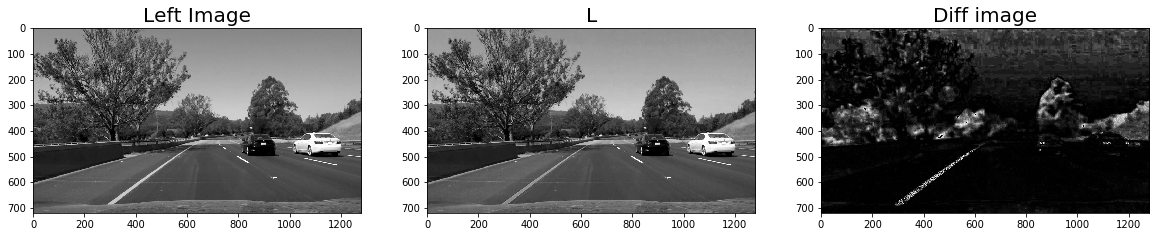

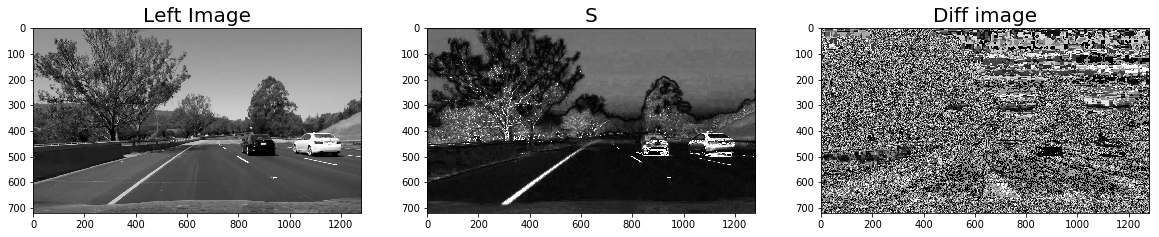

In [76]:
# PLot images in HLS and H, L and S color space
test_image_path = "test_images/test6.jpg"
test_image = cv2.imread(test_image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2HLS)
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

R = test_image_rgb[:, :, 0]
G = test_image_rgb[:, :, 1]
B = test_image_rgb[:, :, 2]

def gray_image_mag_threshold(gray_img, thresh = (200, 255)):
    binary = np.zeros_like(gray_img)
    binary[(gray_img > thresh[0]) & (gray_img <= thresh[1]) ] = 1
    return binary

def hls_select(img_rgb, thresh=(0, 255)):
    hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

plot_two_images(test_image_rgb, hls, right_title="HLS")
plot_two_images(test_image_gray, R, right_title="R")
plot_two_images(test_image_gray, G, right_title="G")
plot_two_images(test_image_gray, B, right_title="B")
plot_two_images(test_image_gray, H, right_title="H")
plot_two_images(test_image_gray, L, right_title="L")
plot_two_images(test_image_gray, S, right_title="S")




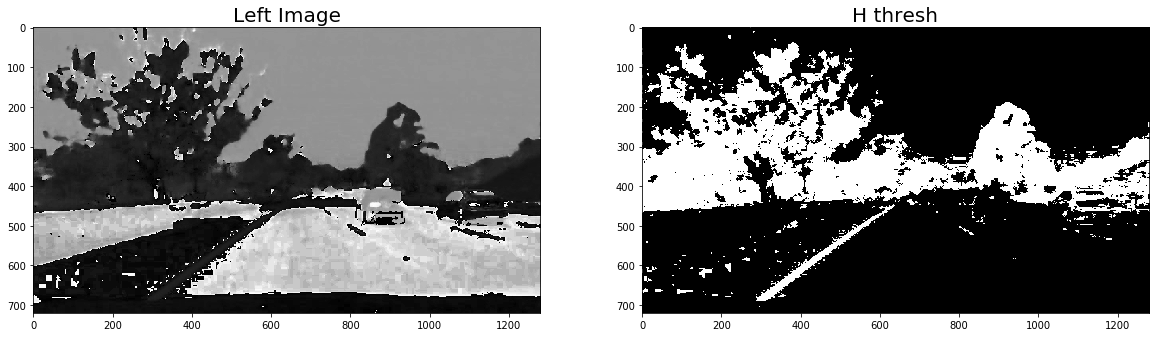

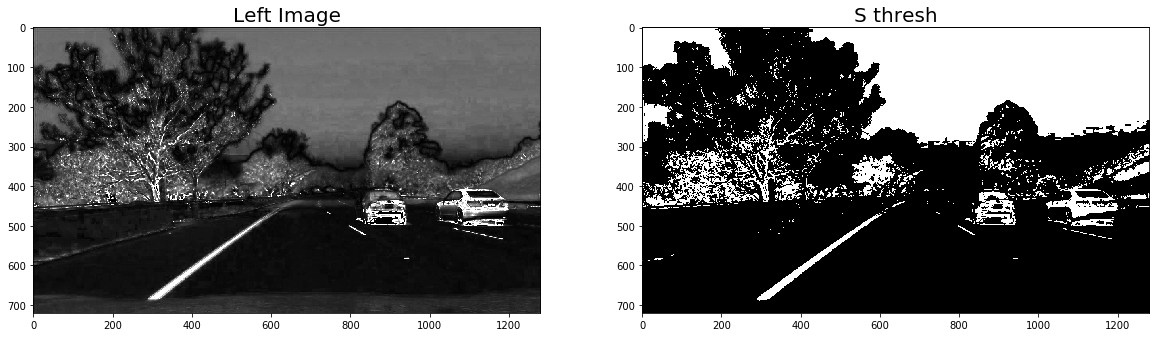

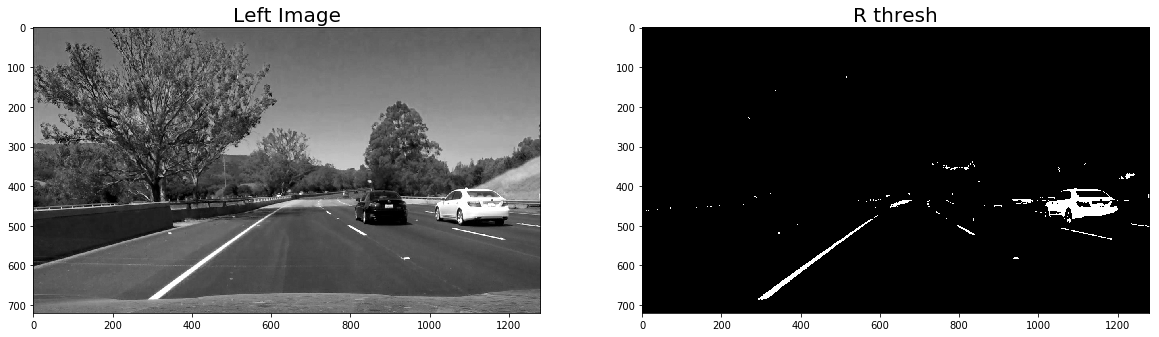

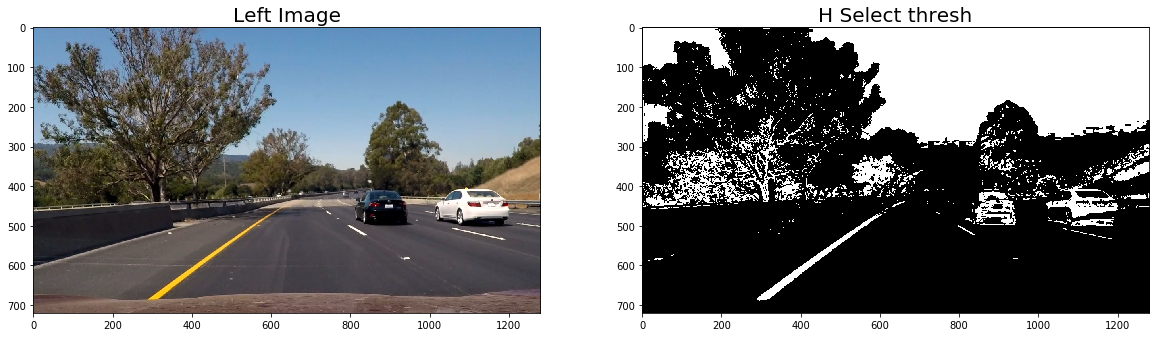

In [49]:
H_thres = gray_image_mag_threshold(H, thresh=(15, 100))
plot_two_images(H, H_thres, right_title="H thresh", plot_diff=False)

S_thres = gray_image_mag_threshold(S, thresh=(90, 255))
plot_two_images(S, S_thres, right_title="S thresh", plot_diff=False)

R_thres = gray_image_mag_threshold(R, thresh=(200, 255))
plot_two_images(R, R_thres, right_title="R thresh", plot_diff=False)

hls_binary = hls_select(test_image_rgb, thresh=(90, 255))
plot_two_images(test_image_rgb, hls_binary, right_title="H Select thresh", plot_diff=False)

# 4.2 Combine Color threshold and gradient threshold

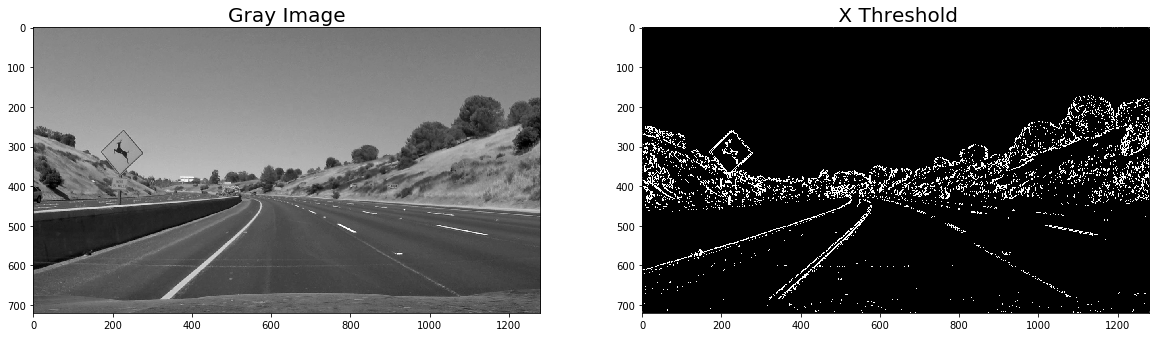

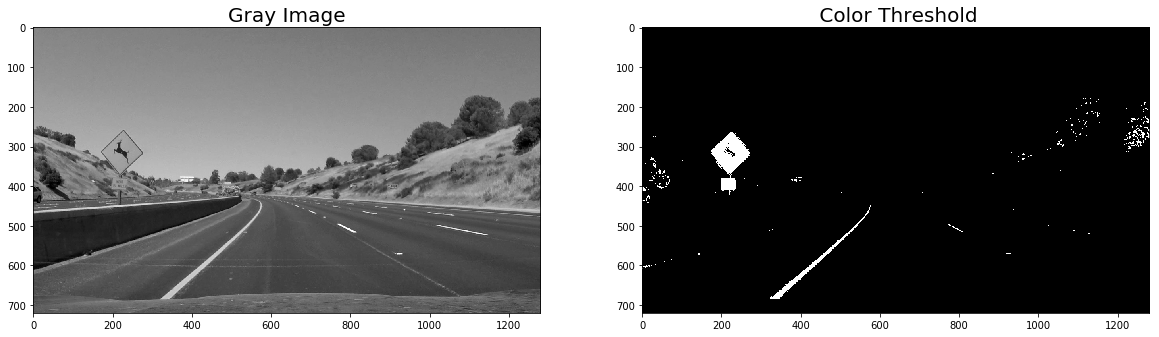

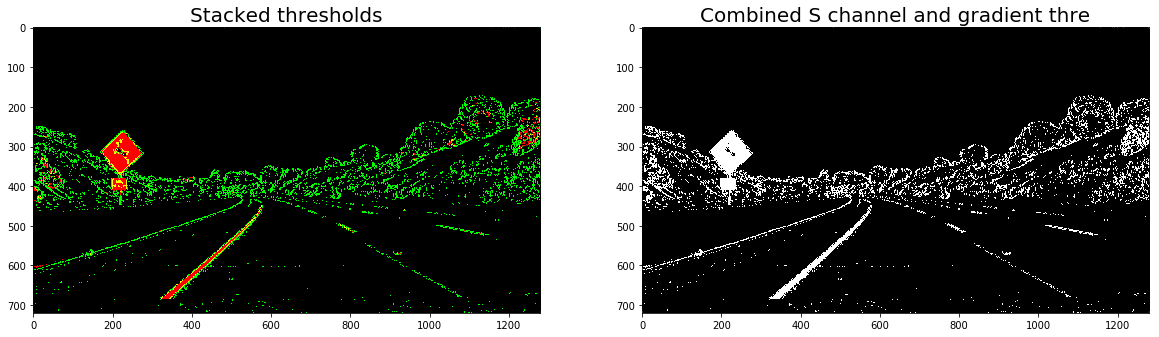

In [85]:
test_image_path = "test_images/test2.jpg"
test_image = cv2.imread(test_image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)


# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better


# Threshold x gradient
sxbinary = abs_sobel_thresh(test_image_rgb, sobel_kernel=3, orient='x', thresh_min=20, thresh_max=100)
plot_two_images(test_image_gray, sxbinary, left_title="Gray Image", right_title=" X Threshold", plot_diff=False)

# Threshold color channel
s_binary = hls_select(test_image_rgb, thresh=(170, 255))
plot_two_images(test_image_gray, s_binary, left_title="Gray Image", right_title=" Color Threshold", plot_diff=False)


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the ts_binarywo binary images, whose components you can see as different colors
color_binary = np.dstack((s_binary, sxbinary, np.zeros_like(sxbinary)))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1


plot_two_images(color_binary, combined_binary, plot_diff=False, left_title="Stacked thresholds", right_title="Combined S channel and gradient thre")


In [ ]:
https://classrooma.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/e6e02d4d-7c80-4bed-a79f-869ef496831b

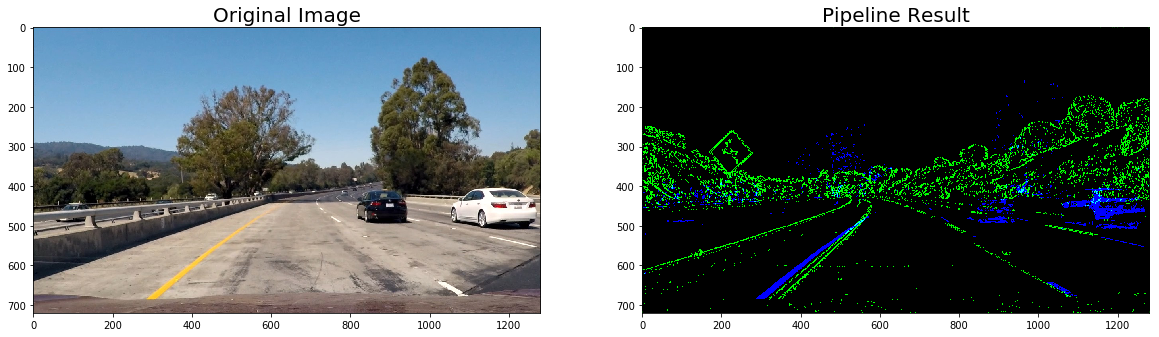

In [90]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


test_image_path = "test_images/test1.jpg"
image = cv2.imread(test_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sxbinary = abs_sobel_thresh(test_image_rgb, sobel_kernel=3, orient='x', thresh_min=sx_thresh[0],
                                thresh_max=sx_thresh[1])
    
    # Threshold s color channel
    s_binary = gray_image_mag_threshold(s_channel, s_thresh)
    # Stack each channel

    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(image)

plot_two_images(image, result, plot_diff=False, left_title="Original Image", right_title="Pipeline Result")


# All Steps so far
1. Camera calibration 
2. Undistort 
3. Color and gradient threshold
4. Perspective tarnsform

'''
In the project at the end of this module, the first thing you'll do is 
to compute the camera calibration matrix and distortion coefficients. You only need to compute these once, and then you'll apply them to undistort each new frame. Next, you'll apply thresholds to create a binary image and then apply a perspective transform.

Thresholding
You'll want to try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible. There's more than one way to achieve a good result, but for example, given the image above, the output you're going for should look something like this:
'''
```
Perspective Transform
Next, you want to identify four source points for your perspective transform. In this case, you can assume the road is a flat plane. This isn't strictly true, but it can serve as an approximation for this project. You would like to pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.
```

In [91]:
# Finding lanes and Slidding Window

In [92]:
# Measuring Curvature